In [178]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from langchain_core.documents import Document
from pinecone import ServerlessSpec
from pinecone import Pinecone
from dotenv import load_dotenv
from sentence_transformers import CrossEncoder
from langchain_openai import OpenAIEmbeddings, OpenAI

load_dotenv()

True

In [25]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
EMBEDDINGS = OpenAIEmbeddings(api_key=os.environ["OPENAI_API_KEY"])
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

### Load document with ids

In [4]:
with open('documents_with_ids.json', 'rb') as f_out:
    documents = json.load(f_out)

In [10]:
documents[60]

{'page_content': 'edema; secondly, the imbalance of intravascular fluid \nexchange, the interstitial fluid generates more than reflux and \nresult in edema. Some of factors that make the liquid from a \ncapillary outflow greater than inflow would result in edema, \nsuch as congestive heart failure, acute nephritis, renal failure, \nthe amount of fluid more than renal excretion, intravascular \nfluid volume increased, or thrombosis, thrombophlebitis \ncause local venous return blocked. Various causes of hypoal-\nbuminemia, such as malnutrition, liver disease, massive pro-\nteinuria, severe diarrhea or high decomposition metabolic \nstate, can cause the plasma colloid osmotic pressure reduced, \nwhich is lead to another important reason for edema. \nCapillary endothelial damage can also lead to increased cap-\nillary permeability, such as bacterial, physical and chemical \nfactors, allergic reactions or immune damage, etc. Lymphatic \nobstruction can cause lymphedema, such as filariasis.

### Load the ground truth dataset

In [2]:
data = pd.read_csv('questions.csv')

ground_truth = data.to_dict(orient='records')

In [11]:
ground_truth[60]

{'question': 'Mediastinal issues or related cardiovascular examination',
 'case_prompt': "A 65-year-old male presents to the clinic with complaints of chest pain and a 'crunching' sound when he breathes, described as intermittent over the past week.",
 'document': '70d62f9f'}

In [16]:
doc_idx = {d['id']: d for d in documents}
doc_idx['70d62f9f']['page_content']

'mediastinal crunch, 103\nmediastinum, 149, 174\nmedical history, in pregnancy, 734\nmedically unexplained symptoms (MUS), 26, \n27b, 847t–850t\nmedication, in neurological history, 497–498, \n498b\nmedulla, anatomy of, 532f\nmedullary brainstem hypercapnia test, 876\nmelaena, 224–225, 268\nmelanoma, metastatic, 821f\nmembranes, rupture of, 732\nMénière’s disease, 495\nmeningocele, 699f\nmeningococcal rash, 871f\nmeningomyelocele, 698t\nmeniscal tear, 434f\nmeniscus sign, 208f\nmenorrhagia, 744\nMENs syndromes see multiple endocrine \nneoplasias (MENs) syndromes\nmenstrual history, 15, 303, 744–750\nmenstruation, 441\nmental health\nof elderly patients, 32–33\ngastrointestinal system and, 234–235\nneurological history and, 497\nrisk, 851\nsystems review of, 9b–12b\nmental health examination, 845–863, \n855t–857t, 863b\nfamily history in, 853\nsocial history in, 853–854\nmeralgia paraesthetica, 425, 575\nmetabolic syndrome, 442, 442t\nmetacarpophalangeal (MCP) joints, 375–379, \n379f'

### Retreival Implementation with reranking using pinecone

In [26]:
pc = Pinecone(api_key=PINECONE_API_KEY)
index = pc.Index("final")

In [27]:
def get_query_embeddings(query: str) -> list[float]:
    query_embeddings = EMBEDDINGS.embed_query(query)
    return query_embeddings

In [28]:
def query_pinecone_index(
    query_embeddings: list, top_k: int = 20, include_metadata: bool = True
) -> dict[str, any]:
    query_response = index.query(
        vector=query_embeddings, top_k=top_k, include_metadata=include_metadata
    )
    return query_response

In [29]:
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

In [30]:
def rerank_documents(query, retrieved_docs):
    
    pairs = []
    doc_list = []

    for doc in retrieved_docs["matches"]:
        text = doc["metadata"].get("page_content") 
        # if text is None:
        #     print(f"Warning: Missing 'page_content' in metadata for document ID {doc['metadata'].get('id', 'Unknown')}")
        #     continue 
        
        pairs.append((query, text))
        doc_list.append(doc)

    if not pairs:
        print("No valid documents found for reranking.")
        return []

    scores = reranker.predict(pairs)

    scored_docs = list(zip(scores, doc_list))
    scored_docs.sort(key=lambda x: x[0], reverse=True)
    reranked_docs = [doc for _, doc in scored_docs]
    
    return reranked_docs

In [58]:
def retreival(q):
    query_text = q['question']
    embeddings = get_query_embeddings(query_text)
    retrieved_results = query_pinecone_index(embeddings, top_k=30)
    reranked_results = rerank_documents(query_text, retrieved_results)
    return reranked_results

### The Rag Flow

In [69]:
def build_prompt(system, search_results):
   
   context = ""
    
    # reduce the length of the search result to include in the prompt because of the context length
   for doc in search_results[:10]:
      context = context + f"content: {doc["metadata"]["page_content"]}\n\n"
      
   prompt_template = f"""You are a medical educator tasked with creating a **clinical case scenario** for an OSCE (Objective Structured Clinical Examination). Your goal is to generate a realistic and detailed case prompt based on the provided **body system/clinical case** and the **context** from the medical database. The case prompt should be suitable for medical students and adhere to OSCE standards for history taking and physical examination.

   ### Instructions:
   1. **Understand the Body System/Clinical Case**:
      - Carefully analyze the provided body system or clinical topic: `{system}`.
      - Consider common pathologies, presentations, and examination techniques related to this system.

   2. **Incorporate Context from the Database**:
      - Use the provided context: `{context}` to ensure the case prompt is grounded in realistic clinical details.
      - Ensure the case aligns with the context while maintaining educational value.

   3. **Generate a Realistic Case Prompt**:
      - The case prompt should include **only the presenting complaint** (e.g., "A 45-year-old male presents with chest pain for 2 hours").
      - Do not include additional history, examination findings, or diagnosis in the prompt.
      - Ensure the complaint is specific, clinically relevant, and appropriate for the given body system.

   4. **Adhere to OSCE Standards**:
      - The case prompt should mimic a real OSCE station, requiring the student to:
      - Take a focused history.
      - Perform a relevant physical examination.
      - Develop a differential diagnosis.
      - Avoid providing excessive details that would make the case too easy or unrealistic.

   5. **Ensure Educational Value**:
      - The case should challenge the student’s clinical reasoning and knowledge.
      - It should be appropriate for the level of a medical student (e.g., not overly complex or obscure).

   ### Input:
   - **Body System/Clinical Case**: {system}
   - **Context from Database**: {context}

   ### Expected Output:
   Provide the output in **parsable JSON** without using code blocks:

   {{
      "case_prompt": "A concise and realistic case prompt based on the body system and context, including only the presenting complaint (e.g., 'A 35-year-old female presents with shortness of breath and fever for 3 days')."
   }}""".strip()
   
   prompt = prompt_template
   
   return prompt

In [70]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [71]:
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = retreival(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

### Cosine similarity

In [72]:
answers = {}

In [75]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    
    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = ground_truth[i]['case_prompt']
    
    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
    }

100%|██████████| 250/250 [26:56<00:00,  6.46s/it]


In [76]:
results_gpt4o_mini = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o_mini[i] = val.copy()
    results_gpt4o_mini[i].update(ground_truth[i])

In [78]:
import pandas as pd

df_gpt4o_mini = pd.DataFrame(results_gpt4o_mini)

In [ ]:

df_gpt4o_mini = pd.DataFrame(df_gpt4o_mini)
df_gpt4o_mini.to_csv('results_gpt4o_mini.csv', index=False)

In [85]:
df_gpt4o_mini = df_gpt4o_mini.to_dict(orient='records')

In [80]:
def get_query_embeddings(query: str) -> list[float]:
    query_embeddings = EMBEDDINGS.embed_query(query)
    return query_embeddings

In [93]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = np.array(get_query_embeddings(answer_llm))
    v_orig = np.array(get_query_embeddings(answer_orig))
    
    return  np.dot(v_llm, v_orig)

In [94]:
similarity = []

for record in tqdm(df_gpt4o_mini):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 250/250 [03:50<00:00,  1.09it/s]


In [ ]:
df_gpt4o_mini = pd.DataFrame(df_gpt4o_mini)

df_gpt4o_mini['cosine'] = list(similarity)
df_gpt4o_mini['cosine'].describe()  

count    250.000000
mean       0.834265
std        0.024178
min        0.743574
25%        0.822991
50%        0.838689
75%        0.850401
max        0.882444
Name: cosine, dtype: float64

In [176]:
df_gpt4o_mini = pd.DataFrame(df_gpt4o_mini)

/tmp/ipykernel_44992/2618774591.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')


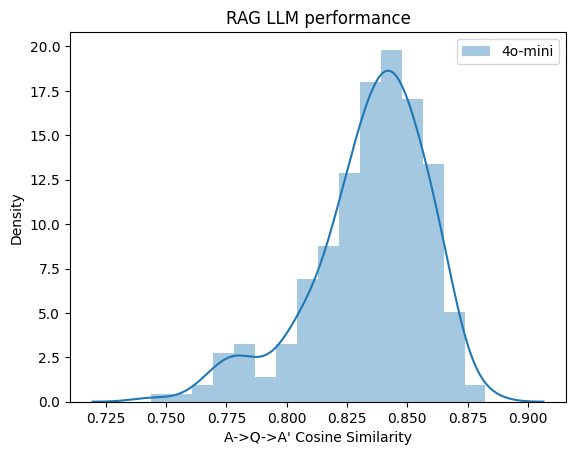

In [177]:
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### Using llm as a judge

In [159]:
def build_prompt(output, system):   
   prompt_template = f"""You are a medical educator tasked with evaluating the **relevance** of a generated case prompt to the provided `{system}`(body system). 
   Your goal is to assess if the `{system}` aligns with the (that the `{system}` and {output} are within the same clinical context) `{output}` case prompt and provide a clear explanation for your evaluation.

      ### Instructions:
      1. **Review the Input and Output**:
         - Carefully analyze the provided system: `{system}`.
         - Review the generated output: `{output}`.

      2. **Evaluate Relevance**:
         - Assess the relevance of the output to the input based on the following criteria:
         - **NON_RELEVANT**: The output does not align with the input at all. It is unrelated or inappropriate for the given context.
         - **PARTLY_RELEVANT**: The output partially aligns with the input but lacks key details or contains inaccuracies.
         - **RELEVANT**: The output fully aligns with the input, demonstrating a clear connection and appropriateness for the given context.

      3. **Provide an Explanation**:
         - Write a brief explanation for your evaluation, highlighting why the output was deemed non-relevant, partly relevant, or relevant.
         - Mention specific aspects of the output that align or misalign with the input.

      ### Input:
      {system}

      ### Output to Evaluate:
      {output}

      ### Expected Output:
      Provide the output in **parsable JSON** without using code blocks:

      {{
      "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
      "Explanation": "[Provide a brief explanation for your evaluation]"
      }}"""
      
   prompt = prompt_template
   
   return prompt

In [131]:
df_gpt4o_mini = df_gpt4o_mini.to_dict(orient='records')

In [156]:
# debugging

for i, record in enumerate(tqdm(df_gpt4o_mini[1:2])):
    # input = record[i]["answer_orig"]\
    system = record["question"]
    output = record["answer_llm"]
    prompt = build_prompt(output, system)
    evaluation = llm(prompt, model='gpt-4o-mini')
    print(evaluation)

100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

{
  "Relevance": "RELEVANT",
  "Explanation": "The case prompt describes a 62-year-old male presenting with palpitations and shortness of breath, which are common symptoms associated with atrial fibrillation. Atrial fibrillation often presents acutely with these symptoms due to the irregular heart rhythm leading to poor cardiac output. The presentation aligns well with the clinical implications of atrial fibrillation, making the case prompt highly relevant to the topic."
}


In [164]:
eval = []

for record in tqdm(df_gpt4o_mini):
    system = record["question"]
    output = record["answer_llm"]
    prompt = build_prompt(output, system)
    evaluation = llm(prompt, model='gpt-4o-mini')
    eval.append(evaluation)

100%|██████████| 250/250 [11:26<00:00,  2.74s/it]


In [165]:
json_evaluations = []

for i, str_eval in enumerate(eval):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [166]:
df_evaluations = pd.DataFrame(json_evaluations)

In [167]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           228
PARTLY_RELEVANT     22
Name: count, dtype: int64

In [169]:
df_evaluations.to_csv('evaluations-aqa.csv', index=False)